<a href="https://www.kaggle.com/code/suehuynh/flood-prediction-eda-xgboost-ensemble?scriptVersionId=180472952" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Flood Prediction - Kaggle Playground May 2024

Goal: The goal of this competition is to predict the probability of a region flooding based on various factors.

# Preparation
### Import libraries

In [1]:
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical computing
from datetime import datetime
import scipy.stats as stats      # For statistical analysis
import math
import matplotlib                # For plotting and visualization
import matplotlib.pyplot as plt  
from pandas.plotting import parallel_coordinates
import seaborn as sns            # For statistical data visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Load datasets

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv',index_col=0)
df_test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col=0)
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv',index_col=0)

# Exploratory Data Analysis

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 745305 entries, 1117957 to 1863261
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   MonsoonIntensity                 745305 non-null  int64
 1   TopographyDrainage               745305 non-null  int64
 2   RiverManagement                  745305 non-null  int64
 3   Deforestation                    745305 non-null  int64
 4   Urbanization                     745305 non-null  int64
 5   ClimateChange                    745305 non-null  int64
 6   DamsQuality                      745305 non-null  int64
 7   Siltation                        745305 non-null  int64
 8   AgriculturalPractices            745305 non-null  int64
 9   Encroachments                    745305 non-null  int64
 10  IneffectiveDisasterPreparedness  745305 non-null  int64
 11  DrainageSystems                  745305 non-null  int64
 12  CoastalVulnerability        

In [5]:
df_train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [6]:
df_train.nunique()

MonsoonIntensity                   17
TopographyDrainage                 19
RiverManagement                    17
Deforestation                      18
Urbanization                       18
ClimateChange                      18
DamsQuality                        17
Siltation                          17
AgriculturalPractices              17
Encroachments                      19
IneffectiveDisasterPreparedness    17
DrainageSystems                    18
CoastalVulnerability               18
Landslides                         17
Watersheds                         17
DeterioratingInfrastructure        18
PopulationScore                    19
WetlandLoss                        20
InadequatePlanning                 17
PoliticalFactors                   17
FloodProbability                   83
dtype: int64

**Observations:**
- Train dataset has 1,117,957 rows x 21 columns, of 20 predictors and FloodProbability being the target for the model.
- Test dataset has 745,305 rows x 21 columns of 20 predictors and 1 ID column.
- Both datasets are very structured and 'clean' with no missing values.
- All the predictors are numerical and specifically, integers.


In [7]:
df_train.describe().T.style

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.000000,4.921450,2.056387,0.000000,3.000000,5.000000,6.000000,16.000000
TopographyDrainage,1117957.000000,4.926671,2.093879,0.000000,3.000000,5.000000,6.000000,18.000000
RiverManagement,1117957.000000,4.955322,2.072186,0.000000,4.000000,5.000000,6.000000,16.000000
Deforestation,1117957.000000,4.942240,2.051689,0.000000,4.000000,5.000000,6.000000,17.000000
Urbanization,1117957.000000,4.942517,2.083391,0.000000,3.000000,5.000000,6.000000,17.000000
ClimateChange,1117957.000000,4.934093,2.057742,0.000000,3.000000,5.000000,6.000000,17.000000
DamsQuality,1117957.000000,4.955878,2.083063,0.000000,4.000000,5.000000,6.000000,16.000000
Siltation,1117957.000000,4.927791,2.065992,0.000000,3.000000,5.000000,6.000000,16.000000
AgriculturalPractices,1117957.000000,4.942619,2.068545,0.000000,3.000000,5.000000,6.000000,16.000000
Encroachments,1117957.000000,4.949230,2.083324,0.000000,4.000000,5.000000,6.000000,18.000000


# Data Visualization
### Univariate Analysis
First, let's look at the distribution of each predictor.

<Axes: xlabel='FloodProbability', ylabel='Count'>

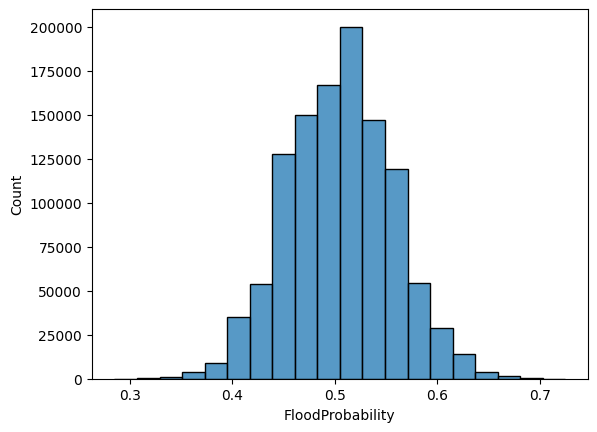

In [8]:
sns.histplot(data = df_train['FloodProbability'], bins = 20)

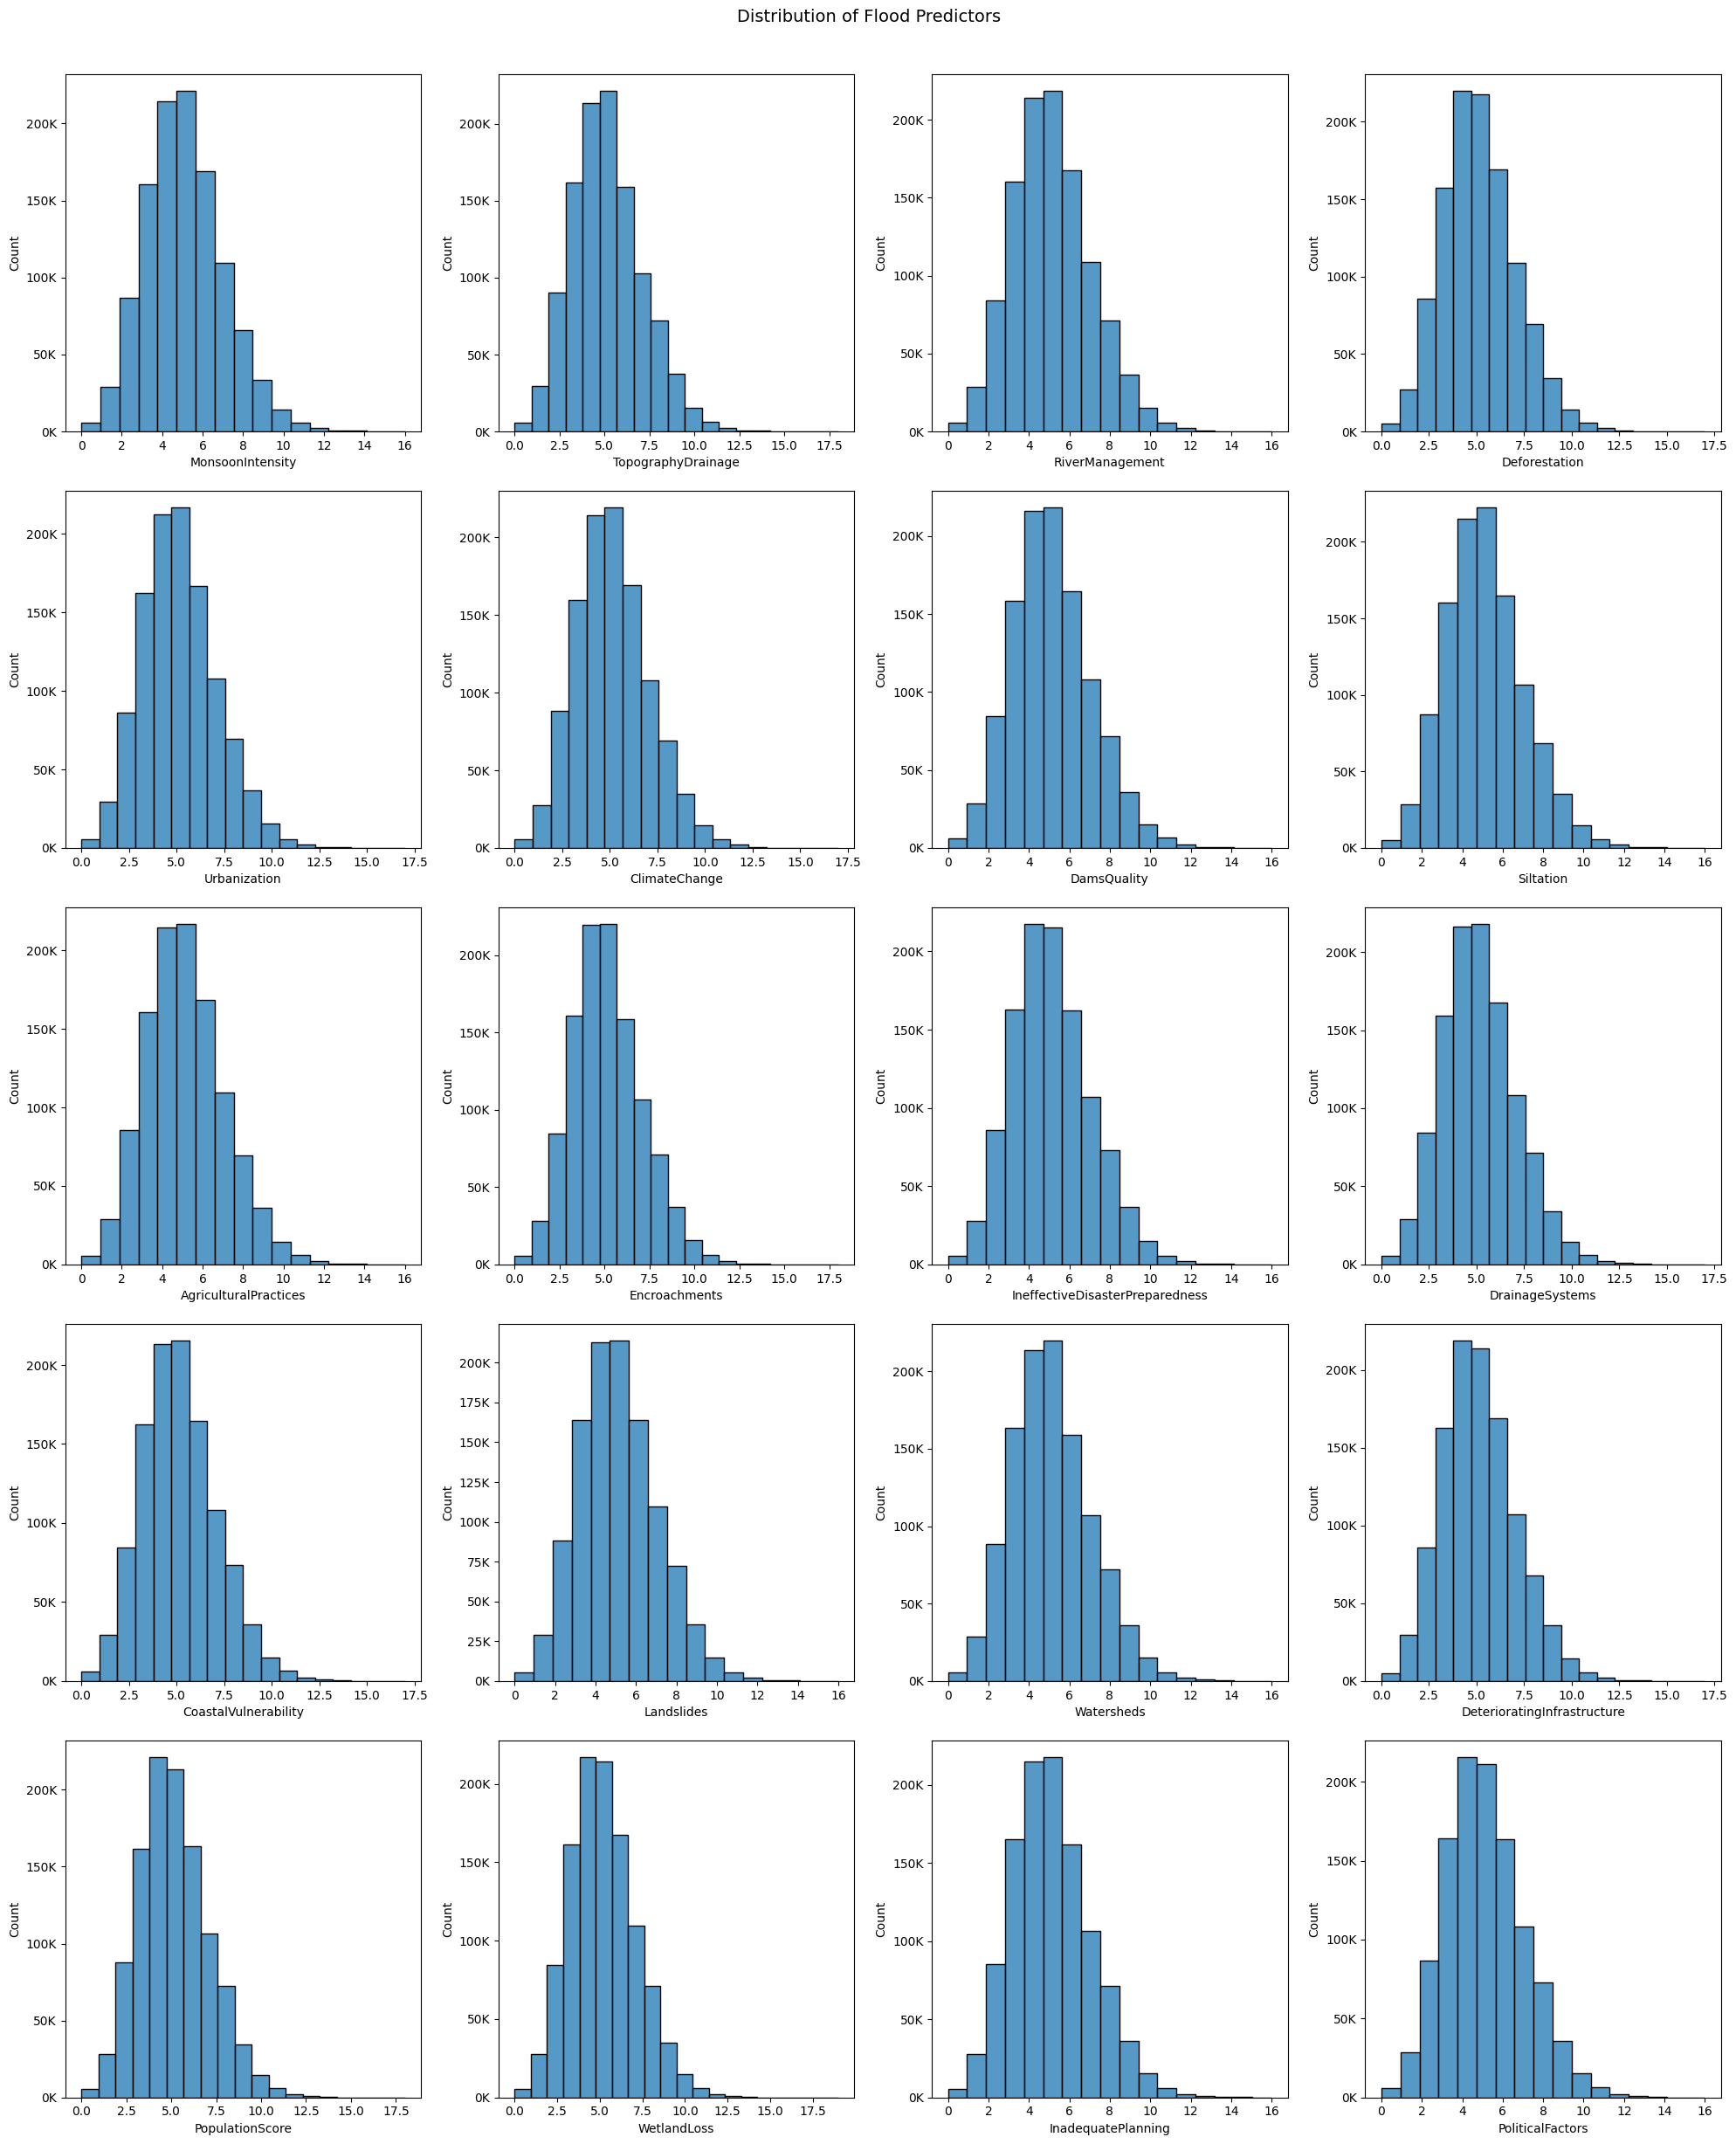

In [9]:
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
 
for i, column in enumerate(df_train.columns):
    if column == 'FloodProbability':
        continue
    plt.subplots_adjust(top = 0.85)
    ax = sns.histplot(data = df_train, 
                x = column, 
                bins = df_train[column].nunique(),
                ax = axes[i // 4, i % 4])
    
    ax.set_yticklabels(['{:,.0f}K'.format(ticks / 1000) for ticks in ax.get_yticks()])
fig.tight_layout(h_pad = 2)
plt.subplots_adjust(top = 0.95)
plt.suptitle('Distribution of Flood Predictors', fontsize = 14)
plt.show()

**Observation**: The predictors are slightly right-skew normally distributed with the mean around 4.0 to 6.0.

### Multivariate Analysis
Next, let's examine the correlation of predictor-to-predictor and predictor-to-target using correlation heatmap.

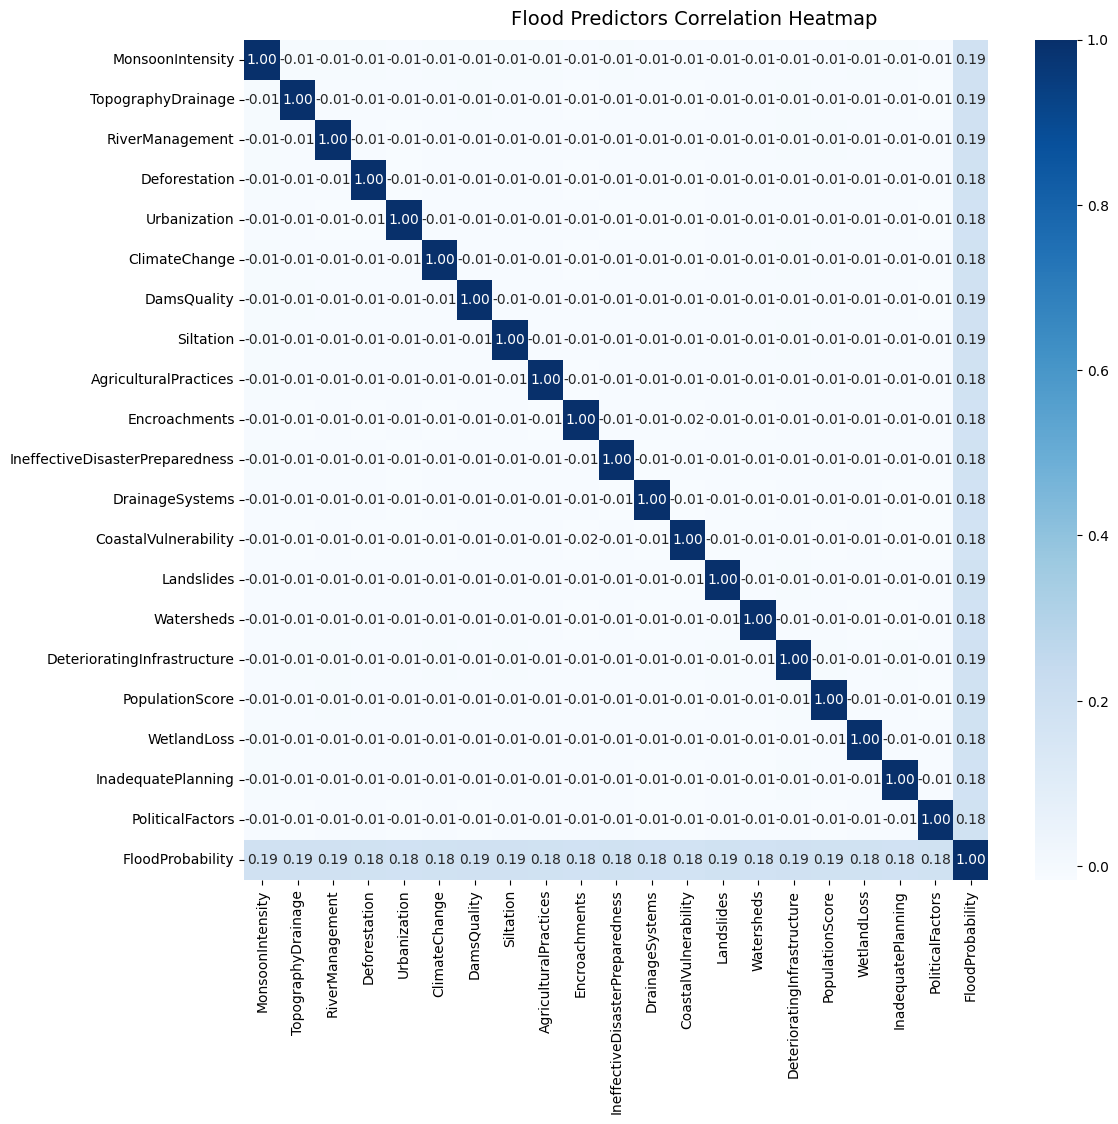

In [10]:
# Correlation Matrix Heatmap
fig, ax = plt.subplots(figsize = (12,10))
corr = df_train.corr()
hm = sns.heatmap(corr,
                annot = True,
                ax = ax,
                cmap = 'Blues',
                fmt = '.2f')
fig.subplots_adjust(top = 0.95)
plt.suptitle('Flood Predictors Correlation Heatmap', fontsize = 14)
plt.show()

**Observations:**
- There are very low correlation among the predictors, showing their independence in the model. We will not need to remove any of them!
- Each predictor has the similar correlation with the target at around 0.18 to 0.19.

**Actions:**
- Visualize the relationship of each predictor-to-target pairs to uncover patterns using scatterplots.

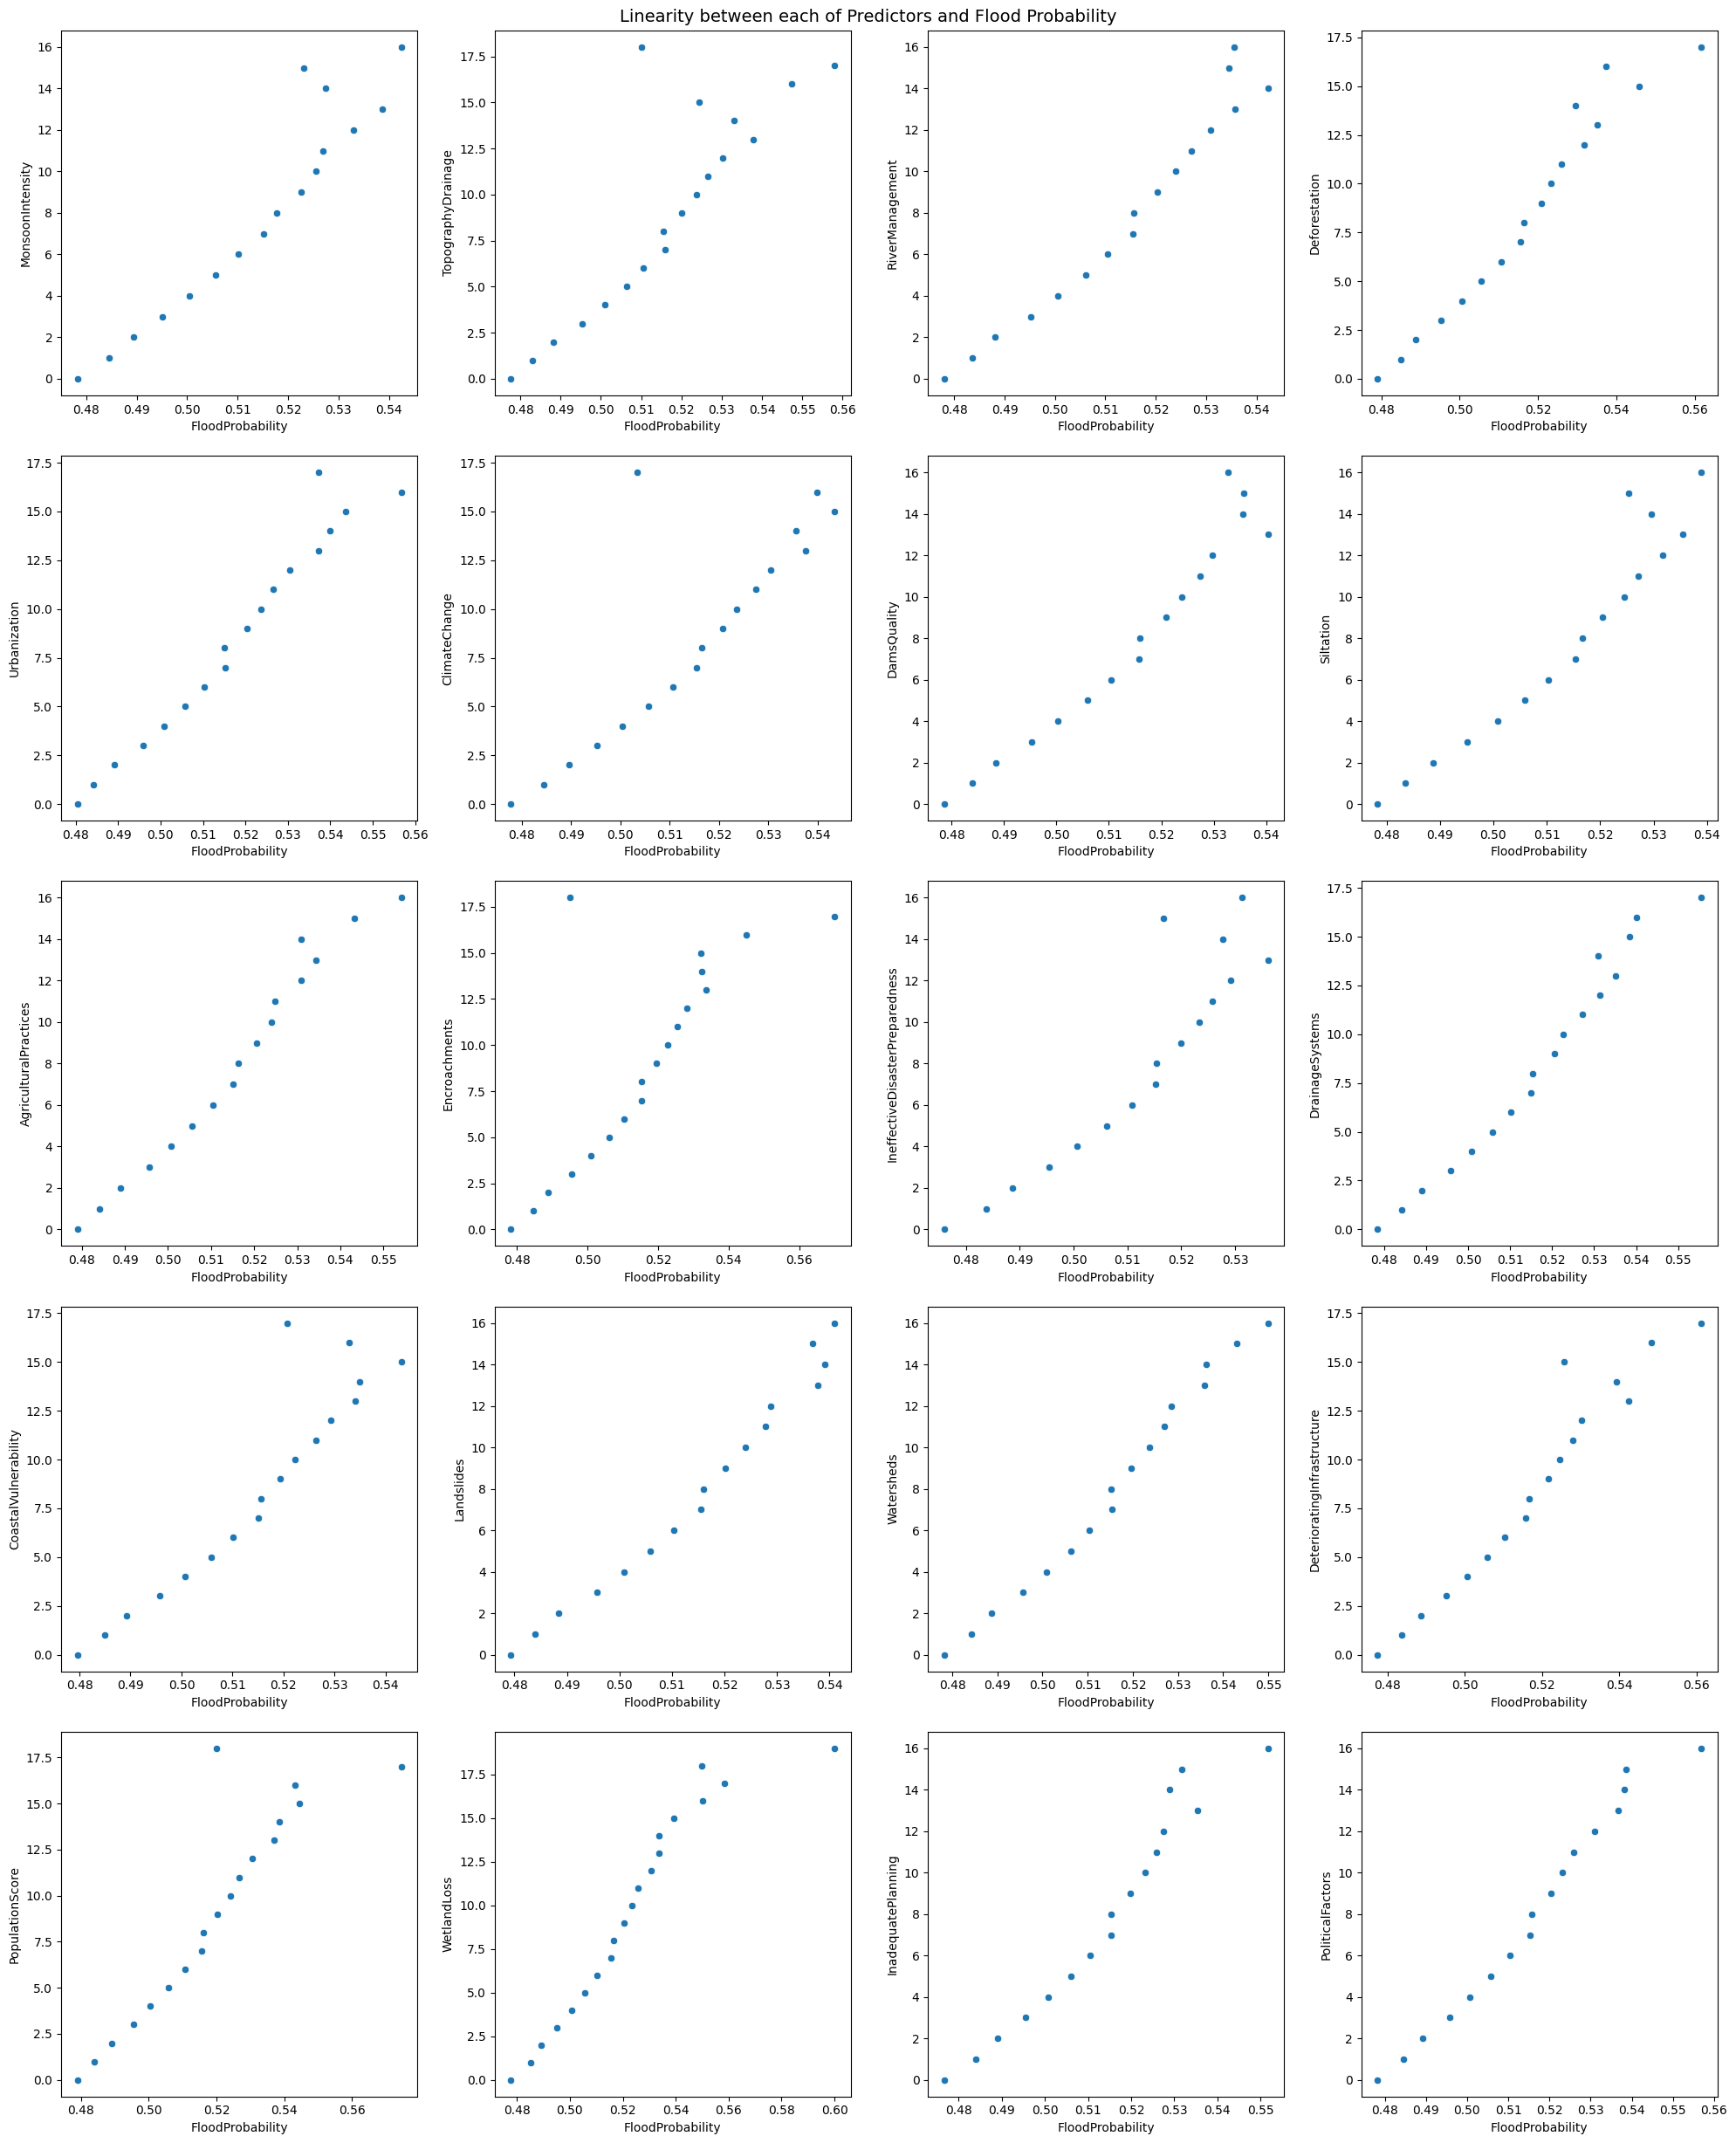

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(20, 25))

for i, column in enumerate(df_train.columns):
    if column == 'FloodProbability':
        continue
    temp_df = df_train[['FloodProbability', column]].groupby(column).mean().reset_index()
    plt.subplots_adjust(top = 0.85)
    ax = sns.scatterplot(data = temp_df,
                y = column,
                x = 'FloodProbability',
                ax = axes[i // 4, i % 4])

fig.tight_layout(h_pad = 2)
fig.subplots_adjust(top = 0.97)
plt.suptitle('Linearity between each of Predictors and Flood Probability', fontsize = 14)
plt.show()

**Observations** - There is a **strong linear relationship** between each predictor to the target. The `FloodProbability` tends to increase as the predictor increases in their values. Hence, Linear Regression might be a good candidate for the prediction.

# Feature Engineering
**Credit to**
- https://www.kaggle.com/code/trupologhelper/ps4e5-openfe-blending-explain

Each newly created feature represents a combination or interaction between the original features, which can be more informative for predicting the likelihood of floods. Here's an explanation of each new feature:

- 'total': The sum of all original features for each data row. 📈
- 'mean': The average value of the original features for each data row. 🌡️
- 'std': The standard deviation of the original features for each data row. 📏
- 'max': The maximum value among the original features for each data row. 📈
- 'min': The minimum value among the original features for each data row. 📉
- 'median': The median of the original features for each data row. 📊
- 'ptp': The range (difference between the maximum and minimum values) of the original features for each data row. 📏
- 'q25': The 25th percentile (first quartile) of the original features for each data row. 📊
- 'q75': The 75th percentile (third quartile) of the original features for each data row. 📊
- 'ClimateImpact': The sum of monsoon intensity and climate change, indicating the overall impact of climatic factors. 🌍
- 'AnthropogenicPressure': The sum of deforestation, urbanization, agricultural practices, and encroachments, representing anthropogenic pressure on the environment. 🏭
- 'InfrastructureQuality': The sum of dam quality, drainage systems, and deteriorating infrastructure, indicating the overall quality of infrastructure. 🏗️
- 'CoastalVulnerabilityTotal': The sum of coastal vulnerability and landslides, representing the total vulnerability of coastal areas. 🌊
- 'PreventiveMeasuresEfficiency': The sum of river management, ineffective disaster preparedness, and inadequate planning, indicating the effectiveness of preventive measures. 🚧
- 'EcosystemImpact': The sum of wetland loss and watersheds, representing the impact on ecosystems. 🌿
- 'SocioPoliticalContext': The product of population assessment and political factors, indicating the socio-political context. 👥
- 'FloodVulnerabilityIndex': The average sum of anthropogenic pressure, infrastructure quality, total coastal vulnerability, and preventive measures efficiency, representing the flood vulnerability index. 🌊
- 'PopulationDensityImpact': The product of population assessment, urbanization, and encroachments, indicating the impact of population density. 👨‍👩‍👧‍👦
- 'DeforestationUrbanizationRatio': The ratio of deforestation to urbanization. 🌳🏙️
- 'AgriculturalEncroachmentImpact': The product of agricultural practices and encroachments, representing the impact of agricultural encroachments. 🚜
- 'DamDrainageInteraction': The product of dam quality and drainage systems, indicating the interaction between dams and drainage. 🏰🚰
- 'LandslideSiltationInteraction': The product of landslides and siltation, representing the interaction between landslides and siltation. ⛰️💧
- 'WatershedWetlandRatio': The ratio of watersheds to wetland loss. 🌊🌿
- 'PoliticalPreparednessInteraction': The product of political factors and ineffective disaster preparedness, indicating the interaction between politics and preparedness. 🏛️🚧
- 'TopographyDrainageSiltation': The sum of topographic drainage and siltation. 🗺️💧
- 'ClimateAnthropogenicInteraction': The product of climate impact and anthropogenic pressure, representing the interaction between climate and anthropogenic factors. 🌍🏭
- 'InfrastructurePreventionInteraction': The product of infrastructure quality and preventive measures efficiency, indicating the interaction between infrastructure and prevention. 🏗️🚧
- 'CoastalEcosystemInteraction': The product of total coastal vulnerability and ecosystem impact, representing the interaction between coastal areas and ecosystems. 🌊🌿

These new features are designed to capture various aspects and interactions that may influence the likelihood of floods, potentially improving the performance of the regression mode

In [12]:
df_test.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

In [13]:
BASE_FEATURES = df_test.columns

def add_features(df):
    df['total'] = df[BASE_FEATURES].sum(axis=1)
    df['mean'] = df[BASE_FEATURES].mean(axis=1)
    df['std'] = df[BASE_FEATURES].std(axis=1)
    df['max'] = df[BASE_FEATURES].max(axis=1)
    df['min'] = df[BASE_FEATURES].min(axis=1)
    df['median'] = df[BASE_FEATURES].median(axis=1)
    df['ptp'] = df[BASE_FEATURES].values.ptp(axis=1)
    df['q25'] = df[BASE_FEATURES].quantile(0.25, axis=1)
    df['q75'] = df[BASE_FEATURES].quantile(0.75, axis=1)
    
    df['ClimateImpact'] = df['MonsoonIntensity'] + df['ClimateChange']
    df['AnthropogenicPressure'] = df['Deforestation'] + df['Urbanization'] + df['AgriculturalPractices'] + df['Encroachments']
    df['InfrastructureQuality'] = df['DamsQuality'] + df['DrainageSystems'] + df['DeterioratingInfrastructure']
    df['CoastalVulnerabilityTotal'] = df['CoastalVulnerability'] + df['Landslides']
    df['PreventiveMeasuresEfficiency'] = df['RiverManagement'] + df['IneffectiveDisasterPreparedness'] + df['InadequatePlanning']
    df['EcosystemImpact'] = df['WetlandLoss'] + df['Watersheds']
    df['SocioPoliticalContext'] = df['PopulationScore'] * df['PoliticalFactors']


    df['FloodVulnerabilityIndex'] = (df['AnthropogenicPressure'] + df['InfrastructureQuality'] +
                                     df['CoastalVulnerabilityTotal'] + df['PreventiveMeasuresEfficiency']) / 4
    
    df['PopulationDensityImpact'] = df['PopulationScore'] * (df['Urbanization'] + df['Encroachments'])
    
    df['DeforestationUrbanizationRatio'] = df['Deforestation'] / df['Urbanization']
    
    df['AgriculturalEncroachmentImpact'] = df['AgriculturalPractices'] * df['Encroachments']
    
    df['DamDrainageInteraction'] = df['DamsQuality'] * df['DrainageSystems']
    
    df['LandslideSiltationInteraction'] = df['Landslides'] * df['Siltation']
    
    df['WatershedWetlandRatio'] = df['Watersheds'] / df['WetlandLoss']
    
    df['PoliticalPreparednessInteraction'] = df['PoliticalFactors'] * df['IneffectiveDisasterPreparedness']
    
    
    df['TopographyDrainageSiltation'] = df['TopographyDrainage'] + df['Siltation']
    
    df['ClimateAnthropogenicInteraction'] = df['ClimateImpact'] * df['AnthropogenicPressure']
    
    df['InfrastructurePreventionInteraction'] = df['InfrastructureQuality'] * df['PreventiveMeasuresEfficiency']
    
    df['CoastalEcosystemInteraction'] = df['CoastalVulnerabilityTotal'] * df['EcosystemImpact']

    return df

df_train = add_features(df_train)
df_test = add_features(df_test)

In [14]:
df_train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DeforestationUrbanizationRatio,AgriculturalEncroachmentImpact,DamDrainageInteraction,LandslideSiltationInteraction,WatershedWetlandRatio,PoliticalPreparednessInteraction,TopographyDrainageSiltation,ClimateAnthropogenicInteraction,InfrastructurePreventionInteraction,CoastalEcosystemInteraction
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,1.333333,12,20,9,1.0,6,11,189,182,60
1,6,7,4,4,8,8,3,5,4,6,...,0.500000,24,21,0,1.0,27,12,308,255,12
2,6,5,6,7,3,7,1,5,4,5,...,2.333333,20,7,35,2.5,18,10,247,210,70
3,3,4,6,5,4,8,4,7,6,8,...,1.250000,48,8,49,0.8,25,11,253,180,99
4,5,3,2,6,4,4,3,3,3,3,...,1.500000,9,6,18,3.0,25,6,144,90,64


# Machine Learning
### Preparation

In [15]:
target = 'FloodProbability'
features = [col for col in df_train.columns if col != target ]

X = df_train[features]
y = df_train[target]

In [16]:
# For machine learning
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor,RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.model_selection import KFold
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

### Preprocessing

In [17]:
for column in X.columns:
    X[column].replace([np.inf, -np.inf], np.nan, inplace = True)
    mean = X[column].mean(skipna=True)
    X[column].fillna(mean, inplace = True)
X.isnull().any().sum()

0

### Model Selection
# Multiple Linear Regression

In [18]:
lm = LinearRegression()

# Fit the data(train the model) 
lm.fit(X, y) 

# Predict
y_predicted = lm.predict(X)

# Model evaluation
r2 = r2_score(y, y_predicted) 

# printing values 
print('Slope:' ,lm.coef_) 
print('Intercept:', lm.intercept_) 
print('R2 score: ', r2) 

Slope: [ 1.71522055e-04  3.46336222e-04  2.09376660e-04  2.16169561e-04
  1.61962623e-04  2.21593869e-04  1.28246792e-04  2.55952083e-04
  6.56585080e-05  2.56665011e-05  6.99920692e-05  1.09287038e-04
  2.77680759e-04  1.66761502e-04  2.66965398e-04  1.76969326e-04
  7.43062014e-04  2.67943860e-04  1.52306543e-04  7.14957932e-04
  4.74841132e-03  2.37420566e-04 -1.95638892e-04 -1.46852605e-04
  8.74697270e-05 -2.48202097e-04 -2.34322332e-04 -4.23029578e-04
 -3.71841388e-04  3.93115924e-04  4.69457193e-04  4.14503157e-04
  4.44442261e-04  4.31675273e-04  5.34909259e-04  2.46403738e-05
  4.40019471e-04  1.16118029e-05  4.71792259e-05  2.36917035e-05
  1.78629053e-05  1.65901036e-05  1.95894028e-05  2.30278400e-05
  6.02288305e-04  1.77038712e-05  1.46330999e-05  1.41549720e-05]
Intercept: -0.039950082891962446
R2 score:  0.8451649458792386


# XGBoost

In [19]:
# Create XGBoost model
xgb = XGBRegressor(booster = 'gbtree',
                   max_depth = 10,
                   num_leaves = 250,
                   reg_alpha = 0.1,
                   reg_lambda = 3.25,
                   learning_rate = 0.01,
                   n_estimators = 3000,
                   subsample_for_bin= 165700, 
                   min_child_samples= 114, 
                   colsample_bytree= 0.9634,
                   subsample= 0.9592, 
                   random_state = 0)

n_splits = 5
# Create a KFold cross-validator
kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)

scores = []
# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index]
    y_train, y_valid = y[train_index], y[val_index]
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)
    score = r2_score(y_valid, y_pred)
    print(score)
    scores.append(score)

# Output the average R2 score across all folds
print(f'Mean R2 score: {np.mean(scores):.5f}')

0.8684264242427042
0.8690013519936679
0.8682970427416723
0.868591164906649
0.8685795623277885
Mean R2 score: 0.86858


# CatBoost Regressor

In [20]:
# Create CatBoostRegressor model
catb = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       verbose = 0)

n_splits = 5
# Create a KFold cross-validator
kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)

scores = []
# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index]
    y_train, y_valid = y[train_index], y[val_index]
    catb.fit(X_train, y_train)
    y_pred = catb.predict(X_valid)
    score = r2_score(y_valid, y_pred)
    print(score)
    scores.append(score)

# Output the average R2 score across all folds
print(f'Mean R2 score: {np.mean(scores):.5f}')

0.8683135851417726
0.8688586105266276
0.8681427799099749
0.8685368382239325
0.8684549030407658
Mean R2 score: 0.86846


# LightGBM

In [21]:
'''n_splits = 5
# Create a KFold cross-validator
kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)
# Create XGBoost model
lgbm = LGBMRegressor(objective = 'regression',
               boosting_type = 'gbdt',
               max_depth = 10,
               num_leaves = 250,
               reg_alpha = 0.1,
               reg_lambda = 3.25,
               learning_rate = 0.01,
               n_estimators = 3000,
               subsample_for_bin= 165700, 
               min_child_samples= 114, 
               colsample_bytree= 0.9634,
               subsample= 0.9592, 
               random_state = 0,
               verbosity = -1)
scores = []
# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index]
    y_train, y_valid = y[train_index], y[val_index]
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_valid)
    score = r2_score(y_valid, y_pred)
    print(score)
    scores.append(score)

# Output the average R2 score across all folds
print(f'Mean R2 score: {np.mean(scores):.5f}')'''

"n_splits = 5\n# Create a KFold cross-validator\nkf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)\n# Create XGBoost model\nlgbm = LGBMRegressor(objective = 'regression',\n               boosting_type = 'gbdt',\n               max_depth = 10,\n               num_leaves = 250,\n               reg_alpha = 0.1,\n               reg_lambda = 3.25,\n               learning_rate = 0.01,\n               n_estimators = 3000,\n               subsample_for_bin= 165700, \n               min_child_samples= 114, \n               colsample_bytree= 0.9634,\n               subsample= 0.9592, \n               random_state = 0,\n               verbosity = -1)\nscores = []\n# Perform K-Fold Cross-Validation\nfor train_index, val_index in kf.split(X):\n    X_train, X_valid = X.iloc[train_index], X.iloc[val_index]\n    y_train, y_valid = y[train_index], y[val_index]\n    lgbm.fit(X_train, y_train)\n    y_pred = lgbm.predict(X_valid)\n    score = r2_score(y_valid, y_pred)\n    print(score)\n

# Stacking Ensemble
Use StackingCVRegressor to apply multiple regression methods to yield high accuracy and stability!

In [22]:
'''r1 = catb
r2 = xgb
#r3 = lgbm
r4 = lm
r5 = HistGradientBoostingRegressor(learning_rate = 0.05,
                                   max_iter = 400)
r6 = GradientBoostingRegressor(learning_rate = 0.05,
                               n_estimators = 400)
r7 = RandomForestRegressor(n_estimators = 400,
                           max_depth = 4)
r8 = SVR(kernel='linear')

stack = StackingCVRegressor(regressors=(r1, r2, r4, r5, r6, r7, r8),
                            meta_regressor = CatBoostRegressor(verbose = 0),
                            cv = KFold(n_splits=5))'''

"r1 = catb\nr2 = xgb\n#r3 = lgbm\nr4 = lm\nr5 = HistGradientBoostingRegressor(learning_rate = 0.05,\n                                   max_iter = 400)\nr6 = GradientBoostingRegressor(learning_rate = 0.05,\n                               n_estimators = 400)\nr7 = RandomForestRegressor(n_estimators = 400,\n                           max_depth = 4)\nr8 = SVR(kernel='linear')\n\nstack = StackingCVRegressor(regressors=(r1, r2, r4, r5, r6, r7, r8),\n                            meta_regressor = CatBoostRegressor(verbose = 0),\n                            cv = KFold(n_splits=5))"

In [23]:
'''stack.fit(X, y)'''

'stack.fit(X, y)'

In [24]:
'''r1 = CatBoostRegressor(n_estimators = 1000,
                       learning_rate = 0.05,
                       verbose = 0)
r2 = xgb
r3 = lgb
r4 = HistGradientBoostingRegressor(learning_rate = 0.05,
                                   max_iter = 400)
r5 = GradientBoostingRegressor(learning_rate = 0.05,
                               n_estimators = 400)
r6 = RandomForestRegressor(n_estimators = 400,
                           max_depth = 4)
r7 = LinearRegression()
r8 = SVR(kernel='linear')

stack = StackingCVRegressor(regressors=(r1, r2, r3, r4,r5,r6,r7,r8),
                            meta_regressor = CatBoostRegressor(verbose = 0),
                            cv = KFold(n_splits=10))'''

"r1 = CatBoostRegressor(n_estimators = 1000,\n                       learning_rate = 0.05,\n                       verbose = 0)\nr2 = xgb\nr3 = lgb\nr4 = HistGradientBoostingRegressor(learning_rate = 0.05,\n                                   max_iter = 400)\nr5 = GradientBoostingRegressor(learning_rate = 0.05,\n                               n_estimators = 400)\nr6 = RandomForestRegressor(n_estimators = 400,\n                           max_depth = 4)\nr7 = LinearRegression()\nr8 = SVR(kernel='linear')\n\nstack = StackingCVRegressor(regressors=(r1, r2, r3, r4,r5,r6,r7,r8),\n                            meta_regressor = CatBoostRegressor(verbose = 0),\n                            cv = KFold(n_splits=10))"

In [25]:
'''r1 = catb
r2 = xgb
r3 = lgb
r4 = lm

stack = StackingCVRegressor(regressors=(r1, r2, r3, r4),
                            meta_regressor = CatBoostRegressor(verbose = 0),
                            cv = KFold(n_splits=10))'''

'r1 = catb\nr2 = xgb\nr3 = lgb\nr4 = lm\n\nstack = StackingCVRegressor(regressors=(r1, r2, r3, r4),\n                            meta_regressor = CatBoostRegressor(verbose = 0),\n                            cv = KFold(n_splits=10))'

In [26]:
'''n_splits = 5
# Create a KFold cross-validator
kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)

scores = []
# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index]
    y_train, y_valid = y[train_index], y[val_index]
    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_valid)
    score = r2_score(y_valid, y_pred)
    print(score)
    scores.append(score)

# Output the average R2 score across all folds
print(f'Mean R2 score: {np.mean(scores):.5f}')'''

"n_splits = 5\n# Create a KFold cross-validator\nkf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)\n\nscores = []\n# Perform K-Fold Cross-Validation\nfor train_index, val_index in kf.split(X):\n    X_train, X_valid = X.iloc[train_index], X.iloc[val_index]\n    y_train, y_valid = y[train_index], y[val_index]\n    stack.fit(X_train, y_train)\n    y_pred = stack.predict(X_valid)\n    score = r2_score(y_valid, y_pred)\n    print(score)\n    scores.append(score)\n\n# Output the average R2 score across all folds\nprint(f'Mean R2 score: {np.mean(scores):.5f}')"

In [27]:
'''stack.fit(X, y)'''

'stack.fit(X, y)'

In [28]:
'''for clf, label in zip([r1, r2, r3, r4,r5,r6,r7,r8, stack], ['CatBoostRegressor', 'XGBRegressor', 
                                                        'LGBMRegressor', 'HistGradientBoostingRegressor',
                                                         'GradientBoostingRegressor','RandomForestRegressor','LinearRegression',
                                                            'SVR','StackingCVRegressor']):
    clf.fit(X, y)
    scores = cross_val_score(clf, X, y, cv=2, scoring='r2')
    print("R2 Score: %0.2f (+/- %0.2f) [%s]" % (
        scores.mean(), scores.std(), label))'''

'for clf, label in zip([r1, r2, r3, r4,r5,r6,r7,r8, stack], [\'CatBoostRegressor\', \'XGBRegressor\', \n                                                        \'LGBMRegressor\', \'HistGradientBoostingRegressor\',\n                                                         \'GradientBoostingRegressor\',\'RandomForestRegressor\',\'LinearRegression\',\n                                                            \'SVR\',\'StackingCVRegressor\']):\n    clf.fit(X, y)\n    scores = cross_val_score(clf, X, y, cv=2, scoring=\'r2\')\n    print("R2 Score: %0.2f (+/- %0.2f) [%s]" % (\n        scores.mean(), scores.std(), label))'

## Submission

In [29]:
X_submission = df_test[features]

In [30]:
y_xgb_pred = xgb.predict(X_submission)
#y_lgb_pred = lgbm.predict(X_submission)
y_cat_pred = catb.predict(X_submission)

In [31]:
y_submission_pred = 0.5*y_xgb_pred + 0.5*y_cat_pred

In [32]:
'''y_submission_pred = stack.predict(X_submission)'''

'y_submission_pred = stack.predict(X_submission)'

In [33]:
df_test.reset_index(inplace = True)
df_test

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DeforestationUrbanizationRatio,AgriculturalEncroachmentImpact,DamDrainageInteraction,LandslideSiltationInteraction,WatershedWetlandRatio,PoliticalPreparednessInteraction,TopographyDrainageSiltation,ClimateAnthropogenicInteraction,InfrastructurePreventionInteraction,CoastalEcosystemInteraction
0,1117957,4,6,3,5,6,7,8,7,8,...,0.833333,32,40,35,1.500000,40,13,253,240,120
1,1117958,4,4,2,9,5,5,4,7,5,...,1.800000,20,16,28,1.250000,6,11,207,72,99
2,1117959,1,3,6,5,7,2,4,6,4,...,0.714286,8,36,30,0.833333,21,9,54,315,77
3,1117960,2,4,4,6,4,5,4,3,4,...,1.500000,16,32,18,3.500000,28,7,126,270,90
4,1117961,6,3,2,4,6,4,5,5,3,...,0.666667,21,15,30,1.000000,20,8,200,154,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745300,1863257,5,4,8,3,5,4,4,5,5,...,0.600000,25,24,15,1.250000,30,9,162,304,36
745301,1863258,4,4,2,12,4,3,4,3,5,...,3.000000,25,28,12,1.000000,12,7,182,160,48
745302,1863259,5,7,9,5,5,6,7,5,5,...,1.000000,15,77,55,0.800000,24,12,198,460,126
745303,1863260,4,7,6,3,5,2,3,8,6,...,0.600000,42,18,48,0.285714,30,15,126,204,126


In [34]:
submission = pd.DataFrame({
    "id": df_test["id"],
    "probability": y_submission_pred,
}).set_index('id')

In [35]:
submission.head()

,probability
id,
1117957,0.577684
1117958,0.454865
1117959,0.448209
1117960,0.467672
1117961,0.466730


In [36]:
submission.to_csv("./submission.csv")